In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

#import matplotlib
#matplotlib.use('agg')
#import matplotlib.pyplot as plt 

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
import sys, os, math
import gezi, melt
import numpy as np

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
image_model_name='InceptionResnetV2'
#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/'
#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/exp/'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.coverage.finetune.biglr3/'
if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                      model_name=image_model_name)
else:
  image_model = None

predictor = melt.Predictor(model_dir)

model_dir2 = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.rnn.finetune.later'
#predictor2 = melt.Predictor(model_dir2)

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.2.0-rc0


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words


ENCODE_UNK 1


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/model.ckpt-19.3-318000


restore meta grpah and model ok /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/model.ckpt-19.3-318000 duration: 111.844383955


In [2]:
def predict(image_path, predictor, length_normalization_factor=1., num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  graph = predictor.graph
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          graph.get_collection('feed')[0] : feature
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          graph.get_collection('feed')[0] : feature,
                                          graph.get_collection('beam_search_input_feed')[0] : input_feed,
                                          graph.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=ids2text.end_id(), 
                                   max_words=decode_max_words, 
                                   length_normalization_factor=length_normalization_factor)


  for i, beam in enumerate(beams):
    print(i, beam.words)
    print(ids2text.ids2text(beam.words), math.exp(beam.score))

    # Plot images with attention weights
    words = beam.words    
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 3:  
      for j in range(len(words)):
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(ids2text.vocab.key(words[j]).decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(beam.logprobs[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(beam.alignments_list[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(beam.alignments_list[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    #print('beam search using time(ms):', timer.elapsed_ms())

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [4]:
import glob 
#for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
#    image_show(img)
#    predict(img, predictor)

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:51cf971950328df7f4491dcf4f76780261a89624.jpg


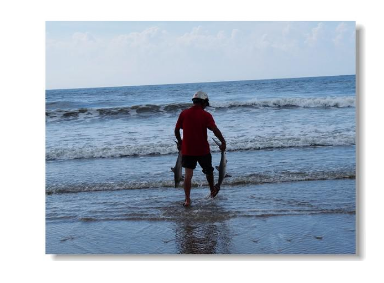

0 [10, 43, 94, 1, 14, 24, 2, 421, 1, 403, 5, 9]
一个 戴着 帽子 的 男人 走 在 海边 的 沙滩 上 </S> 0.732980046952


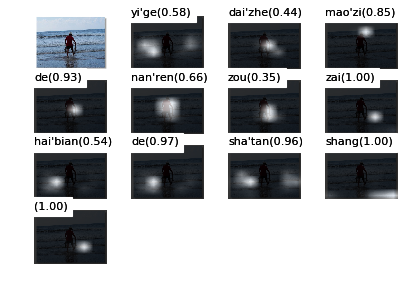

1 [10, 43, 94, 1, 14, 19, 2, 421, 1, 403, 5, 9]
一个 戴着 帽子 的 男人 站 在 海边 的 沙滩 上 </S> 0.698149211713


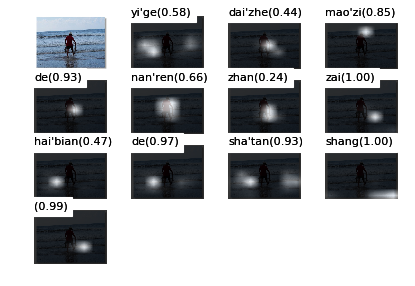

2 [10, 20, 258, 90, 1, 14, 24, 2, 421, 1, 403, 5, 9]
一个 穿着 红色 上衣 的 男人 走 在 海边 的 沙滩 上 </S> 0.674552103723


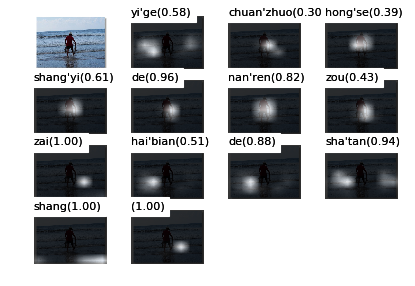

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:dbfa2971caf54f7700e882609bb563ef9b032193.jpg


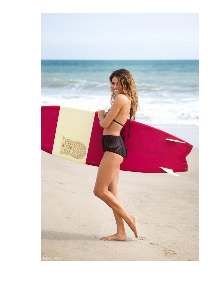

0 [421, 1, 403, 5, 24, 3, 10, 20, 1125, 1, 22, 9]
海边 的 沙滩 上 走 着 一个 穿着 比基尼 的 女人 </S> 0.61623152838


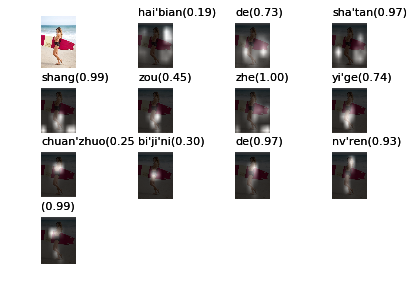

1 [421, 1, 403, 5, 24, 3, 10, 44, 79, 3, 133, 1, 22, 9]
海边 的 沙滩 上 走 着 一个 双手 抱 着 东西 的 女人 </S> 0.581174014103


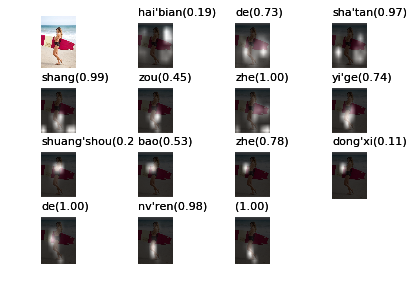

2 [421, 1, 403, 5, 24, 3, 10, 44, 79, 3, 1, 22, 9]
海边 的 沙滩 上 走 着 一个 双手 抱 着 的 女人 </S> 0.539594066484


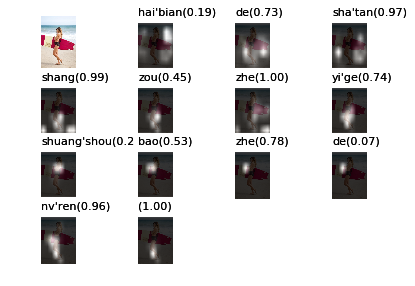

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:3dd309ca864a969381ad0316e3e21d58007974e3.jpg


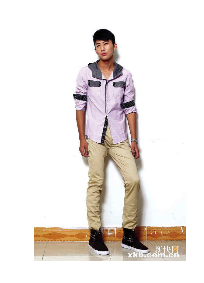

0 [10, 43, 94, 1, 14, 19, 2, 103, 1, 566, 9]
一个 戴着 帽子 的 男人 站 在 室内 的 墙边 </S> 0.667402256435


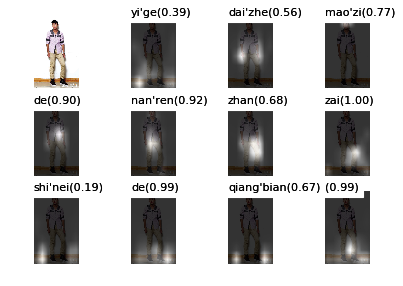

1 [10, 43, 94, 1, 14, 19, 2, 566, 1, 566, 9]
一个 戴着 帽子 的 男人 站 在 墙边 的 墙边 </S> 0.618266304253


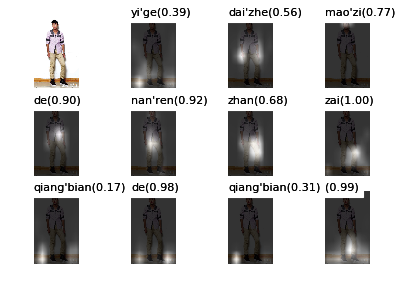

2 [89, 21, 11, 10, 43, 94, 1, 14, 684, 1200, 9]
房间 里 有 一个 戴着 帽子 的 男人 倚靠在 墙上 </S> 0.584791990494


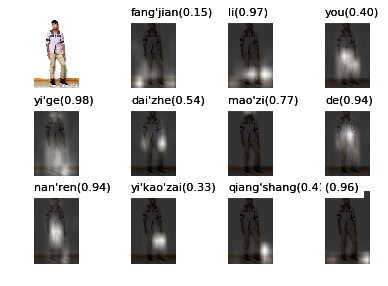

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:d61c36f810ff9f08a51cb9b5c050b657cdead4ac.jp
path not exists:/home/gezi/data2/data/ai_challenger/image_caption/pic/d61c36f810ff9f08a51cb9b5c050b657cdead4ac.jp.jpg
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:d61c36f810ff9f08a51cb9b5c050b657cdead4ac.jpg


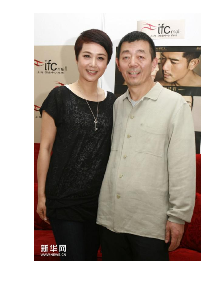

0 [10, 20, 113, 90, 1, 14, 114, 3, 10, 20, 113, 90, 1, 22, 19, 2, 287, 32, 9]
一个 穿着 黑色 上衣 的 男人 搂 着 一个 穿着 黑色 上衣 的 女人 站 在 展板 前 </S> 0.682161255272


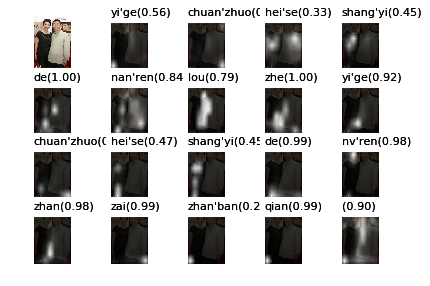

1 [10, 20, 113, 90, 1, 14, 114, 3, 10, 20, 113, 90, 1, 22, 19, 2, 251, 32, 9]
一个 穿着 黑色 上衣 的 男人 搂 着 一个 穿着 黑色 上衣 的 女人 站 在 广告牌 前 </S> 0.676498434072


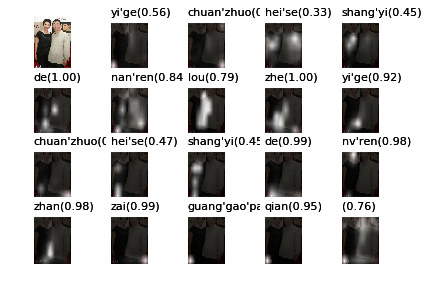

2 [10, 20, 187, 90, 1, 14, 114, 3, 10, 20, 113, 90, 1, 22, 19, 2, 251, 32, 9]
一个 穿着 深色 上衣 的 男人 搂 着 一个 穿着 黑色 上衣 的 女人 站 在 广告牌 前 </S> 0.673968109908


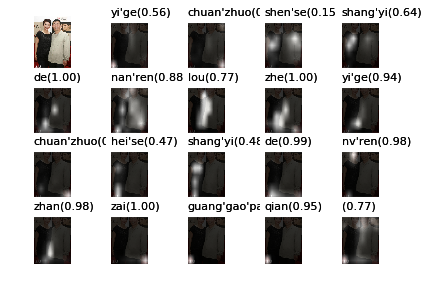

KeyboardInterrupt: 

In [5]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:')
  image_name = image_name.strip()
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)